# Task: Which populations have contracted COVID-19 and require ventilators?

This notebook seeks to find the areas of highest risk in the US which require, or soon will have a dire need, of ventilators.

There is certainly room for improvement in this notebook and I am open to and will appreciate any critical and constructive feedback. Feel free to fork this notebook if you wish to explore any ideas further, I just ask that you credit me if you publish an expanded version. Because of the datasets I chose to use, the recommendations are for the United States and its territories. This notebook attempts to find opportunities for improvement, I am not modeling future activity as I'm hoping for positive disruptive action to render many of the current predictive models overly pessimistic.

Special thanks to:
* Kaggle and its community for hosting the datasets, challenges, and useful material that make notebooks like these possible
* The Roche Data Science Coalition (RDSC) 

Last updated 4/8/2020, to include updated data and touch up some of the visuals

# Part One: the data

This section contains the code for loading and preparing the data, feel free to skip to Part Two for the final table, some visualisations and my conclusions.

In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uncover/UNCOVER/hackathon_file_readme.txt
/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/2019-novel-coronavirus-covid-19-2019-ncov-data-repository-recovered.csv
/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-by-states.csv
/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/2019-novel-coronavirus-covid-19-2019-ncov-data-repository-deaths.csv
/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/2019-novel-coronavirus-covid-19-2019-ncov-data-repository-confirmed-cases-in-the-us.csv
/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases.csv
/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-over-time.csv
/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-by-country.csv
/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/2019-novel-coronavirus-covid-19-2019-ncov-data-repository-confirmed-cases.csv
/kaggle/input/unco

### The Harvard Global Health institute Hospital capacity dataset

This dataset will give us an understanding of the total capacity of hospitals in each state. I will add to this dataset a ratio of hospital beds to people, to get an idea of the state's healthcare capacity in a more scaled manner. The last step is to change the state codes to be full names to use as an index going forward. 

In [2]:
hostipal_beds = pd.read_csv('/kaggle/input/uncover/UNCOVER/harvard_global_health_institute/hospital-capacity-by-state-40-population-contracted.csv')

hostipal_beds['bed_to_people_ratio'] = (hostipal_beds['total_hospital_beds'] + hostipal_beds['total_icu_beds'])/(hostipal_beds['adult_population'] + hostipal_beds['population_65'])

In [3]:
#credit to http://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/ I copied this directly from their site to save myself time
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [4]:
risk = hostipal_beds.sort_values(by=['bed_to_people_ratio'], ascending=False).head(52)
risk['state'] = pd.Series([states[x] for x in risk['state']], index=risk.index)
risk = risk[['state','total_hospital_beds', 'total_icu_beds','adult_population','population_65','bed_to_people_ratio']]
risk.index = risk.state
risk = risk.drop(['state'], axis=1)

### Johns Hopkins University Center Datasets

These datasets contain the rate of infection, number of infected, and mortality rate. As one positive note, there is a substantial lag for incrementing the recovered total, so there is likely a bit of inflation the total infected cases (due to recoveries not being removed at the time of occurance). 

For this part of the dataset, we are extracting the total deaths and confirmed cases by state for the master data frame which is named: ```risk``` . We are also extracting some time series data for the US to visualize how cases are progressing.

In [5]:
cases_by_country = pd.read_csv('/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-by-country.csv')
cases_by_state = pd.read_csv('/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-by-states.csv')
cases_over_time = pd.read_csv('/kaggle/input/uncover/UNCOVER/johns_hopkins_csse/johns-hopkins-covid-19-daily-dashboard-cases-over-time.csv')

In [6]:
cases_over_time = cases_over_time.loc[cases_over_time['country_region'] == 'US']

In [7]:
s = cases_by_state.loc[cases_by_state['country_region'] == 'US']
s = s.rename(columns={"province_state": "state"})
s.index = s.state

In [8]:
risk['confirmed'] = pd.Series([x for x in s['confirmed']], index=s.index)
risk['deaths'] = pd.Series([x for x in s['deaths']], index=s.index)

In [9]:
risk['infected_ratio'] = risk['confirmed']/(risk['population_65'] + risk['adult_population'])
risk['hypothetical_beds_in_use'] = (risk['total_hospital_beds'] + risk['total_icu_beds']) - risk['confirmed']
risk = risk[['total_hospital_beds', 'total_icu_beds', 'adult_population','population_65', 'confirmed', 'deaths','hypothetical_beds_in_use', 'bed_to_people_ratio', 'infected_ratio']]
risk.head(5)

,total_hospital_beds,total_icu_beds,adult_population,population_65,confirmed,deaths,hypothetical_beds_in_use,bed_to_people_ratio,infected_ratio
state,,,,,,,,,
South Dakota,4247.0,150.0,644483.0,132118.0,240,2,4157.0,0.005662,0.000309
North Dakota,3371.0,278.0,575105.0,107196.0,207,3,3442.0,0.005348,0.000303
Mississippi,11877.0,931.0,2259919.0,437027.0,1638,43,11170.0,0.004749,0.000607
District of Columbia,2405.0,401.0,554333.0,79769.0,998,22,1808.0,0.004425,0.001574
Montana,3667.0,248.0,803704.0,176138.0,286,6,3629.0,0.003996,0.000292


When we look below at hospital beds as a total and total population which is infected only two states are short beds. That being said, the minority of cases require hospitalization so this is not immediately a crisis.

In [10]:
risk.loc[risk['hypothetical_beds_in_use'] <= 0]

,total_hospital_beds,total_icu_beds,adult_population,population_65,confirmed,deaths,hypothetical_beds_in_use,bed_to_people_ratio,infected_ratio
state,,,,,,,,,
New York,51713.0,4420.0,15594924.0,3008351.0,122056,4159,-65923.0,0.003017,0.006561
New Jersey,20450.0,1891.0,6960340.0,1353999.0,34124,846,-11783.0,0.002687,0.004104


In [11]:
risk = risk.drop(['hypothetical_beds_in_use'], axis=1)

### Dataset: Our World In Data

This dataset has the frequency per million people, of infection. The US data will be used later for a line plot, to keep the graph concise. I chopped off the section before the US reached 1 case per million (March 7th). 

In [12]:
positive_per_mil = pd.read_csv('/kaggle/input/uncover/UNCOVER/our_world_in_data/per-million-people-tests-conducted-vs-total-confirmed-cases-of-covid-19.csv')
positive_per_mil = positive_per_mil.loc[positive_per_mil['code'] == 'USA']
positive_per_mil = positive_per_mil.loc[positive_per_mil['total_confirmed_cases_of_covid_19_per_million_people_cases_per_million'] >= 1]
positive_per_mil = positive_per_mil.drop('total_covid_19_tests_per_million_people', axis=1)
positive_per_mil = positive_per_mil.drop('code', axis=1)
positive_per_mil = positive_per_mil.drop('entity', axis=1)

### Dataset: Coders against covid

Crowdsourced dataset which has the location of testing facilities. This dataframe is used to find the number of testing facilities per state. 


In [13]:
testing_facilities = pd.read_csv('/kaggle/input/uncover/UNCOVER/coders_against_covid/crowd-sourced-covid-19-testing-locations.csv')
testing_facilities.head()
def stetes(val):
    try:
        return states[val]
    except:
        return val
testing_facilities = pd.read_csv('/kaggle/input/uncover/UNCOVER/coders_against_covid/crowd-sourced-covid-19-testing-locations.csv')
testing_facilities = testing_facilities.drop('is_ready_for_prod', axis=1)
testing_facilities['state'] = pd.Series([stetes(str(x)) for x in testing_facilities['location_address_region']], index=testing_facilities.index)
testing_facilities['increment'] = np.ones(4159) # This allows me to count the occurances by state, I kept wanting to use the select count query notation
testing_facilities.index = testing_facilities['state']
testing_facilities = testing_facilities.drop('location_address_region', axis=1)
testing_facilities = testing_facilities.drop('state', axis=1)

In [14]:
_ = testing_facilities.groupby(['state']).count()#this will create a count of testing centers by state
risk['testing_centers'] = pd.Series([x for x in _['increment']], index=_.index)
risk['testing_centers'] = risk['testing_centers'].fillna(0)

# Part Two: Observations

Below is the master dataframe containing the number of total hospital beds, total intensive care unit beds, adult population, senior population (65+), number of confirmed cases, deaths, a ratio of hospital beds to people, ratio of infected, and total number of testing centers. To avoid being bombarded with too many numbers at once, I would advise only looking at what you're curious about in the table below and I'll show you some more specific details further in. To make the dataframe more skimmable a blue colour gradient has been added to highlight larger values for a given column.

In [15]:

risk.sort_values(by=['state']).style.background_gradient(subset=['total_hospital_beds', 'total_icu_beds',
                                                                'confirmed', 'deaths', 'bed_to_people_ratio',
                                                                'infected_ratio', 'testing_centers'])#bar()

,total_hospital_beds,total_icu_beds,adult_population,population_65,confirmed,deaths,bed_to_people_ratio,infected_ratio,testing_centers
state,,,,,,,,,
Alabama,13959,1870,3.74809e+06,762032,1716,45,0.00350966,0.000380478,74
Alaska,1583,130,552319,74340,171,5,0.00273354,0.000272876,41
Arizona,12868,1742,5.18752e+06,1.10636e+06,2486,64,0.0023213,0.000394987,37
Arkansas,8428,856,2.27223e+06,476167,819,14,0.00337797,0.000297992,46
California,68554,8131,2.98681e+07,5.14845e+06,14036,325,0.00218996,0.000400839,182
Colorado,9620,1264,4.18519e+06,707396,4565,126,0.00222459,0.000933045,53
Connecticut,6894,731,2.83175e+06,575757,5276,165,0.00223771,0.00154835,162
Delaware,1864,249,739679,160565,593,14,0.00234714,0.00065871,0
District of Columbia,2405,401,554333,79769,998,22,0.00442516,0.00157388,0


In [16]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

### States with fewest testing centers

Below we have a filtered version of the table above where we only see the entries which have fewer than 5 listed testing centers. Not having access to testing centers can result in underreporting. Puerto Rico isn't a state and The District of Columbia is part of the state of Maryland, so they might have testing centers not including the ones listed here.

In spite of having few testing centers Delaware, Rhode Island, and Maine, have a moderate infection rate. If there is an issue with capturing and reporting cases in these locations, it would indicate that they probably have a higher invisible population of infected.

In [17]:
risk.loc[risk['testing_centers'] <= 5]

,total_hospital_beds,total_icu_beds,adult_population,population_65,confirmed,deaths,bed_to_people_ratio,infected_ratio,testing_centers
state,,,,,,,,,
District of Columbia,2405.0,401.0,554333.0,79769.0,998,22,0.004425,0.001574,0.0
Maine,3310.0,288.0,1073331.0,250131.0,470,10,0.002719,0.000355,2.0
Puerto Rico,7769.0,739.0,2737636.0,629621.0,475,20,0.002527,0.000141,0.0
Rhode Island,2117.0,279.0,845556.0,170144.0,806,17,0.002359,0.000794,1.0
Delaware,1864.0,249.0,739679.0,160565.0,593,14,0.002347,0.000659,0.0


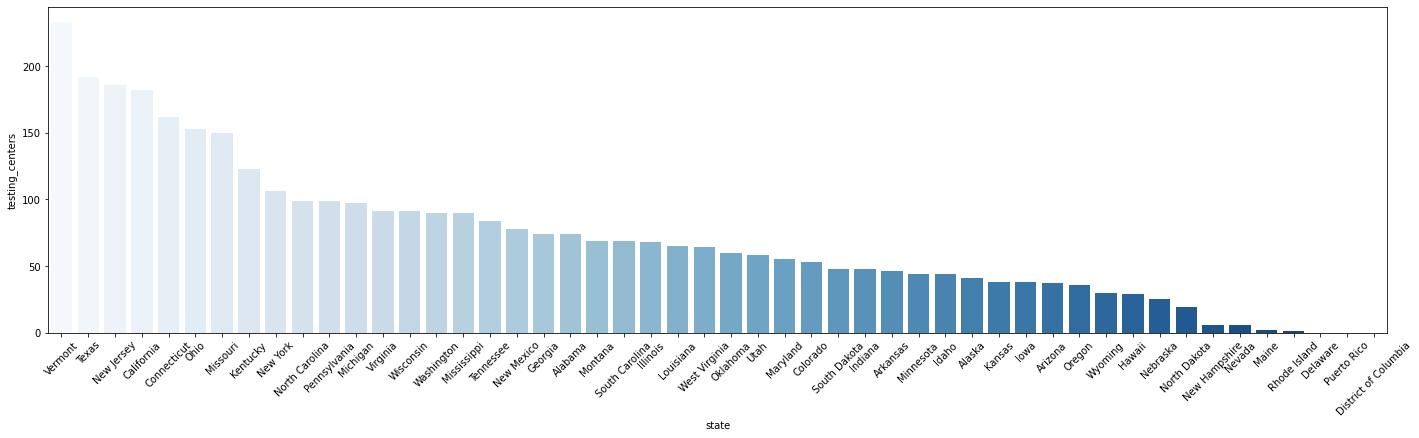

In [18]:
_ = risk.sort_values(by=['testing_centers'], ascending=False).tail(50)
figure(num=None, figsize=(24, 6))
sns.barplot(y=_['testing_centers'], x=_.index, palette='Blues')#,  orient='h')
plt.xticks(rotation=45);

### Healthcare Capacity Hypothesis


Initially I had thought that the number of total hospital beds might represent the healthcare systems capacity. Therefore it might correlate to survival rate of patients or rate of infection. After exploring the data I found this to be a dead end.

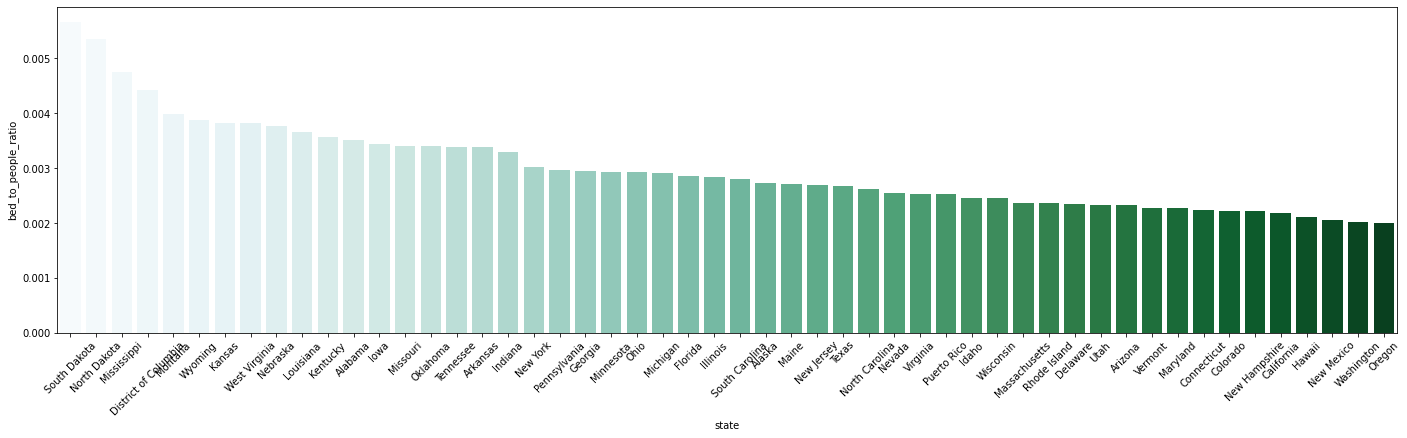

In [19]:
_ = risk.sort_values(by=['bed_to_people_ratio'], ascending=False)
figure(num=None, figsize=(24, 6))
sns.barplot(y=_['bed_to_people_ratio'], x=_.index, palette='BuGn')#,  orient='h')
plt.xticks(rotation=45);

### Highest Rates of Infection

Below we have the states with the highest rate of infection. New York and New Jersey have a really high infection rate, being adjacent geographically this is not overly surprising. Of the states listed only luisiana has a below average number of testing centers available (and only by a slim margin). Louisiana also has a higher rate of morbidity than any of the other states.

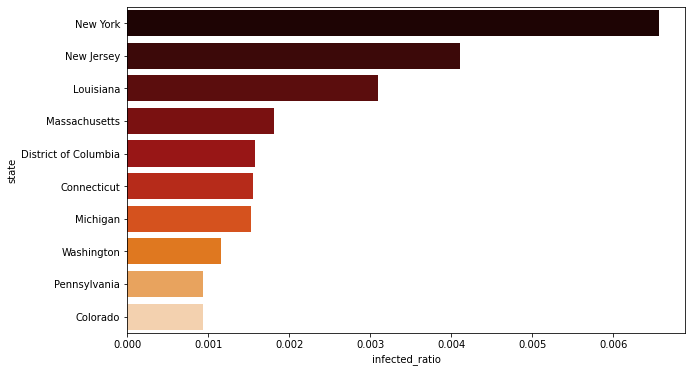

In [20]:
_ = risk.sort_values(by=['infected_ratio'], ascending=False).head(10)
figure(num=None, figsize=(10, 6))
sns.barplot(x=_['infected_ratio'], y=_.index, palette='gist_heat',  orient='h');

### Morbidity Rate:

Covid does not kill instantly, to view the rate of death in a population I created two ratios. Variable M_1 is a ratio of deaths due to covid for the whole population (infected or otherwise), M_2 is a ratio of infected to dead. 

Prior to the dataset update on 4/8 Delaware is in the top ten for morbidity rate by confirmed cases, this state also has zero public testing facilities. They are now ranked much lower. Louisiana has also seen a decline in morbidity. 

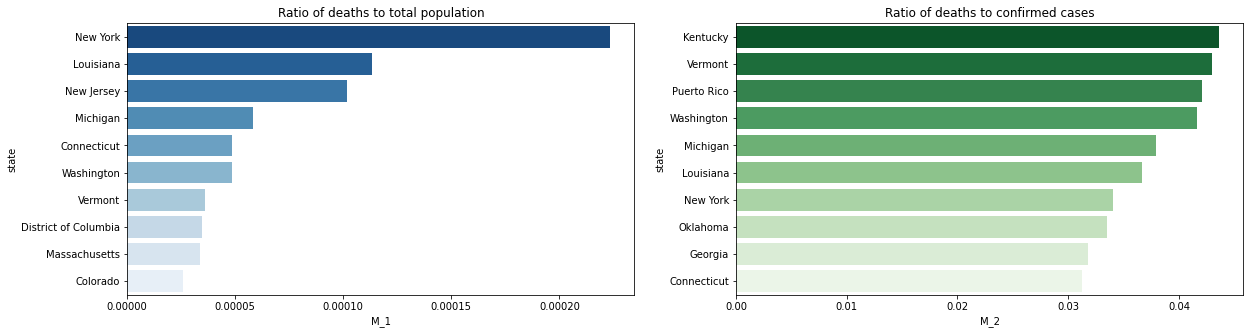

In [21]:
risk['M_1'] = risk['deaths'] / (risk['adult_population'] + risk['population_65'])
risk['M_2'] = risk['deaths'] / risk['confirmed']

fig, ax =plt.subplots(1,2, figsize=(20, 5))
_ = risk.sort_values(by=['M_1'], ascending=False).head(10)
ax[0].set_title('Ratio of deaths to total population')
sns.barplot(x=_['M_1'], y=_.index, palette='Blues_r',  orient='h', ax=ax[0])
_ = risk.sort_values(by=['M_2'], ascending=False).head(10)
ax[1].set_title('Ratio of deaths to confirmed cases')
sns.barplot(x=_['M_2'], y=_.index, palette='Greens_r',  orient='h', ax=ax[1]);

### The same plot from the data prior to 4/8/2020
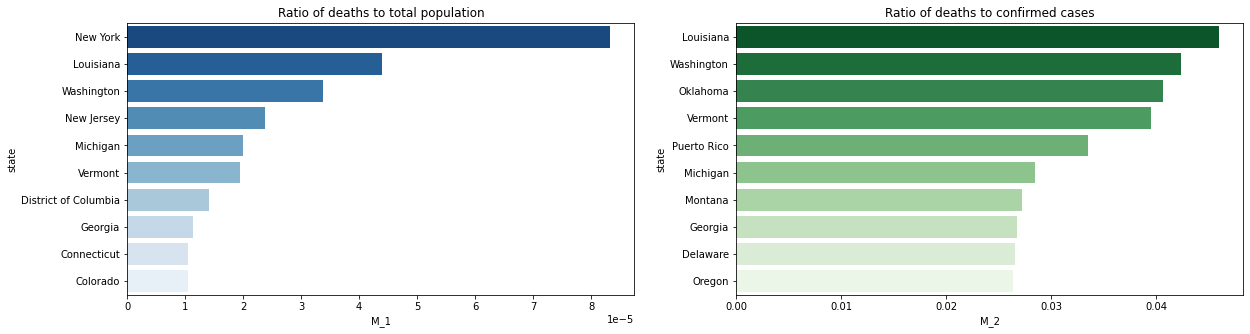

While it may seem like several states has had a rise in mortality rate, morbidity is a lagging indicator. rarely will someone be classified as a confirmed case at the same time as suvival is confirmed positive or negitive (those being post mortem cases)


 # Timeline:

The two graphs below are relatively common, many similar plots are in circulation. These show the number of infected individuals over time and cases per million over time. The time series starts March 7th, when the US hit a rate of 1 person infected for every million. Because of the wider view chosen for the graph, the growth curve will not seem exponential, the wider view is to get a closer look at progression at more of a one day at a time level. As of writing, the dataset only goes through April 4th, I plan to update this notebook as the datasets are updated on Kaggle. 


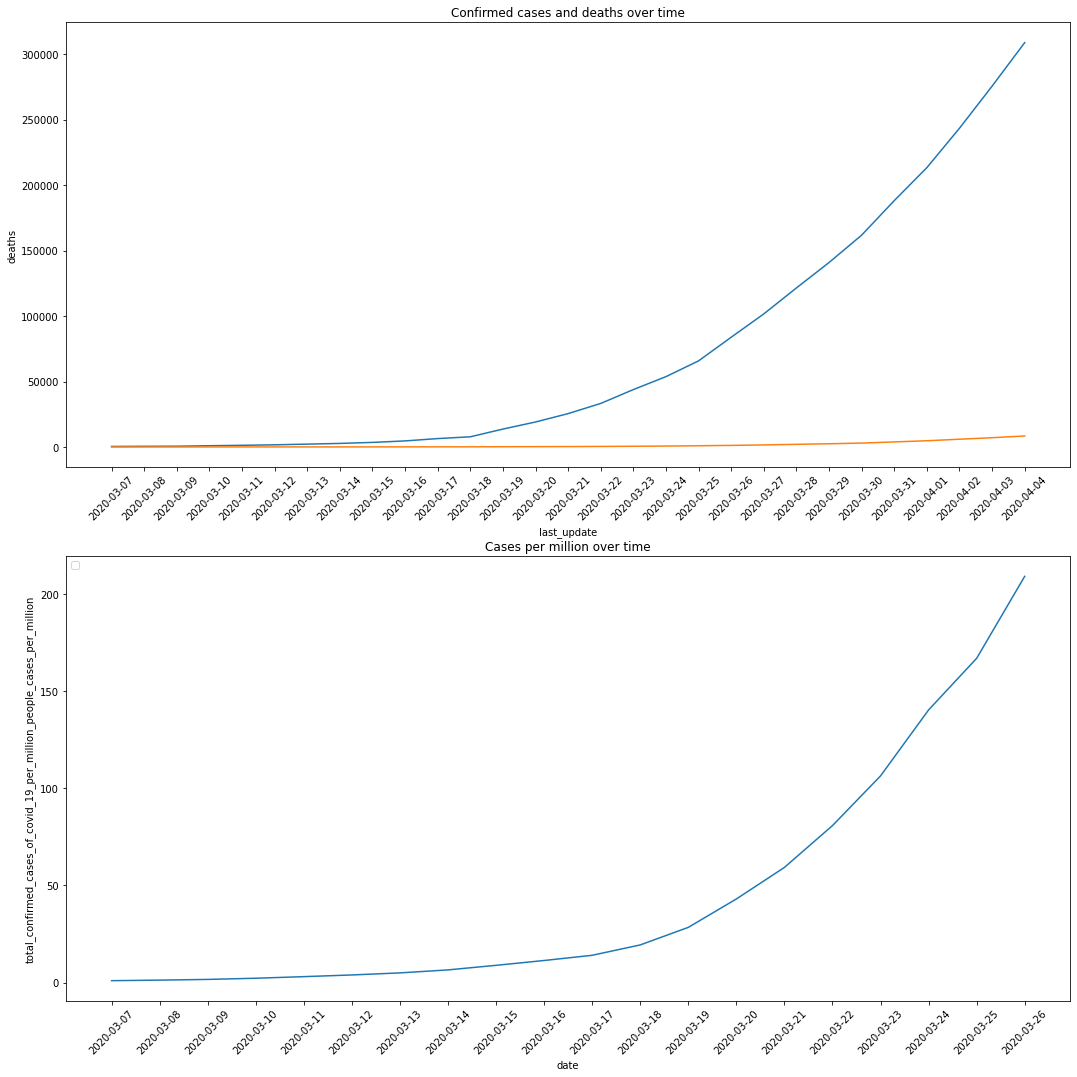

In [22]:
plot_dat = cases_over_time.loc[cases_over_time['confirmed'] >= 400]#this starts this graph at the same date as the one beneith it

fig, ax =plt.subplots(2,1, figsize=(18, 18))

plt.setp(ax[0].get_xticklabels(), rotation=45)
ax[0].set_title('Confirmed cases and deaths over time')
sns.lineplot(x=plot_dat['last_update'], y=plot_dat['confirmed'], ci=None, ax=ax[0])
sns.lineplot(x=plot_dat['last_update'], y=plot_dat['deaths'], ci=None, ax=ax[0])
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend(labels=['Confirmed Cases', 'Deaths'], loc='upper left')

plt.setp(ax[1].get_xticklabels(), rotation=45)
ax[1].set_title('Cases per million over time')
sns.lineplot(x=positive_per_mil.date, y=positive_per_mil.total_confirmed_cases_of_covid_19_per_million_people_cases_per_million, ax=ax[1]);
#plt.xticks(rotation=45);

# Conclusion:

Based on this notebook I would focus on getting ventilators to New York and New Jersey due to their increased infection rate and also Louisiana for their morbidity rates. 

# Final thoughts

There are more answers in the data that I didn't manage to find. There were opportunities to view the data from a county level but I chose to keep it higher level so that I could make a final dataframe that was intelligible when viewed all at once. If one were to view the information at a county level then they might also find the county health rankings dataset useful, one could have aggregated the county level information to get state level answers as well.


This year I've challenged myself to complete one task on Kaggle per week, in order to develop a larger Data Science portfolio. If you found this notebook useful or interesting please give it an upvote. I'm always open to constructive feedback. If you have any questions, comments, concerns, or if you would like to collaborate on a future task of the week feel free to leave a comment here or message me directly. For past TOTW check out the link to my page on github for this ongoing project https://github.com/Neil-Kloper/Weekly-Kaggle-Task/wiki